In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
data = pd.read_csv('./hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('./hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values

In [39]:
#install seaborn for plotting if you don't have it installed
#!pip install seaborn

In [40]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]

In [41]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

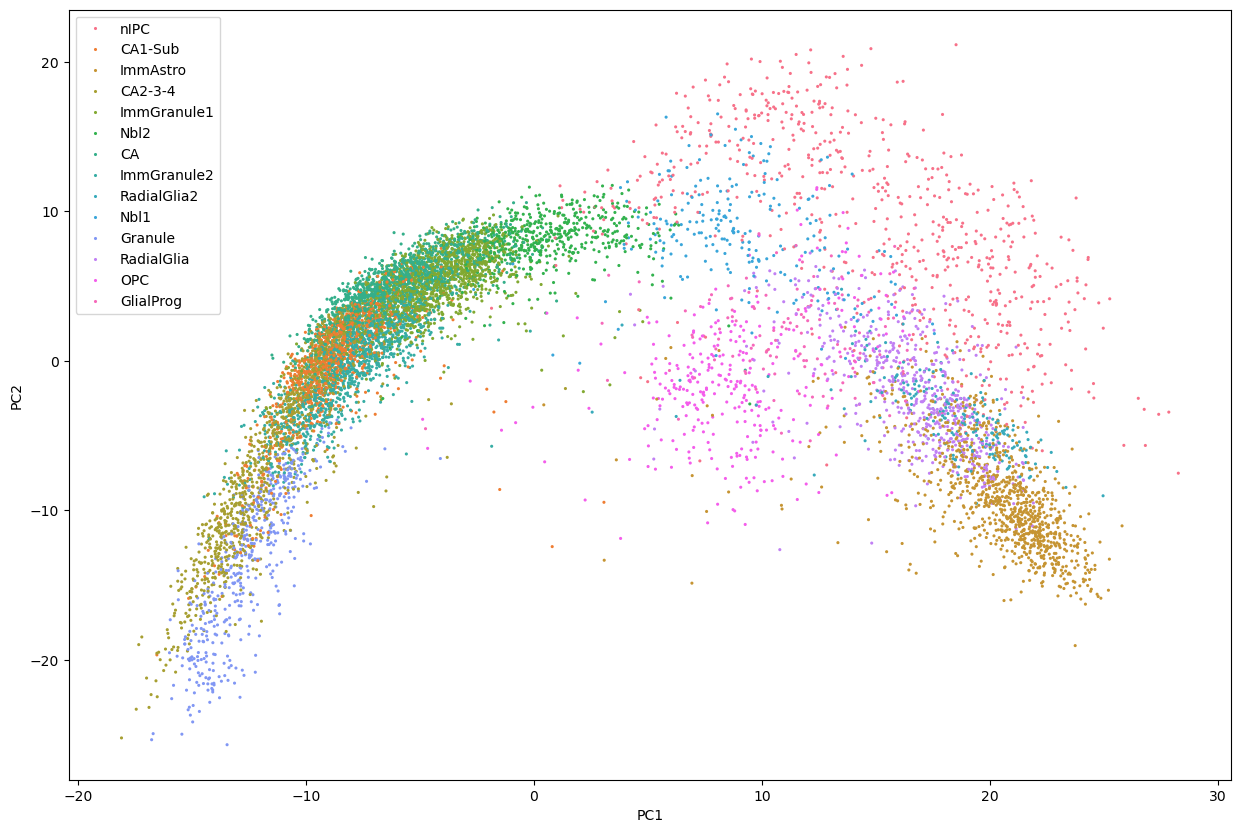

In [42]:
#visualize PCA result
import seaborn
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [43]:
import torch
def get_pytorch_device(device_preference: str | None = None, verbose: bool = True) -> torch.device:
    """
    Determines and returns the appropriate torch.device based on availability
    and user preference.

    Parameters
    ----------
    device_preference : str or None, optional
        User's device preference (e.g., "cuda", "cuda:0", "cuda:1", "cpu", "mps").
        If None, attempts to use the first available CUDA device ('cuda:0'),
        otherwise falls back to CPU. Default is None.
    verbose : bool, optional
        If True, prints information about the device selection and warnings.
        Default is True.

    Returns
    -------
    torch.device
        The selected (and validated) PyTorch device object.

    Raises
    ------
    ValueError
        If the device preference is invalid and cannot be resolved.
    RuntimeError
        If the device preference string is malformed or cannot be parsed.

    Examples
    --------
    >>> device = get_pytorch_device() # Auto-detect
    >>> device = get_pytorch_device("cuda:0")
    """
    final_device_obj = None

    # 1. Handle user's explicit device preference
    if device_preference is not None:
        try:
            potential_device = torch.device(device_preference)

            if potential_device.type == 'cuda':
                if not torch.cuda.is_available():
                    if verbose:
                        warnings.warn(
                            f"CUDA preference '{device_preference}' ignored as CUDA is not available. "
                            "Falling back to CPU."
                        )
                    final_device_obj = torch.device("cpu")
                else:
                    # CUDA is available. Validate the specific CUDA device.
                    if potential_device.index is not None:  # e.g., 'cuda:0', 'cuda:1'
                        if potential_device.index >= torch.cuda.device_count():
                            if verbose:
                                warnings.warn(
                                    f"CUDA device index {potential_device.index} in '{device_preference}' is invalid "
                                    f"(found {torch.cuda.device_count()} CUDA devices). "
                                    f"Falling back to default CUDA device 'cuda:0'."
                                )
                            final_device_obj = torch.device("cuda:0")  # Fallback to the first GPU
                        else:
                            final_device_obj = potential_device  # Valid specific CUDA device
                    else:  # User specified 'cuda' (general)
                        final_device_obj = torch.device("cuda")  # Use default/current CUDA device
            
            else:  # User specified a non-CUDA device (e.g., "cpu", "mps")
                final_device_obj = potential_device
        
        except RuntimeError as e:  # Caused by invalid device_preference string like "foo"
            if verbose:
                warnings.warn(
                    f"Invalid device_preference string '{device_preference}': {e}. "
                    "Autodetecting device instead."
                )
            # Let final_device_obj remain None to trigger autodetection below

    # 2. Autodetect if no valid preference was given or processed
    if final_device_obj is None:
        if torch.cuda.is_available():
            final_device_obj = torch.device("cuda:0")  # Default to first CUDA device
            if verbose and device_preference is None: # Only print if it was pure auto-detection
                 print(f"CUDA is available. Defaulting to {torch.cuda.get_device_name(0)} ({str(final_device_obj)}).")
        else:
            final_device_obj = torch.device("cpu")
            if verbose and device_preference is None: # Only warn if they truly didn't specify and are getting CPU
                 warnings.warn("CUDA is not available. Using CPU. This may result in slower performance.")

    # 3. Final confirmation print (if verbose)
    if verbose:
        device_name_str = ""
        if final_device_obj.type == 'cuda':
            try:
                # For 'cuda' without index, get current_device; else, use specified index
                idx = final_device_obj.index if final_device_obj.index is not None else torch.cuda.current_device()
                device_name_str = f" ({torch.cuda.get_device_name(idx)})"
            except Exception: # Should be rare if logic above is correct
                device_name_str = " (Could not fetch GPU name)"
        
        # Avoid printing if it was already covered by specific warnings/prints for fallbacks
        # This condition ensures it prints if the device was chosen without verbose fallbacks
        if not (device_preference is not None and final_device_obj.type == 'cpu' and 'Falling back to CPU' in [w.message.args[0] for w in warnings.catch_warnings(record=True)]): # Crude check
             print(f"Selected device: {str(final_device_obj)}{device_name_str}")
             
    return final_device_obj

In [44]:
#write and apply your own GraphDR implementation here!
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve
import warnings
def get_top_d_eigenvectors(M) :
    """
    Get the top d eigenvectors of M matrix.
    Parameters
    ----------
    M : torch.Tensor
        The matrix to compute eigenvectors from.
    Returns
    -------
    selected_eigval : torch.Tensor
        The sorted eigenvalues.
    selected_eigvec : torch.Tensor
        The sorted eigenvectors.
    d : int
        The number of top eigenvectors.
    """
    eigval_all, eigvec_all = torch.linalg.eigh(M)
    sorted_eigval, sorted_inx_desc = torch.sort(eigval_all, descending=True)
    sorted_eigvec = eigvec_all[:, sorted_inx_desc]
    eigval_sum = torch.sum(sorted_eigval)
    if eigval_sum < 1e-12:
        warnings.warn("Sum of eigenvalues is close to zero or negative. Cannot determine 'd' based on variance threshold. ")
        return torch.empty(0, device=matrix.device), torch.empty((matrix.shape[0], 0), device=matrix.device), 0
    # Calculate the cumulative sum of eigenvalues
    ratio_val = torch.cumsum(sorted_eigval, dim=0) / eigval_sum
    # Find the index where the cumulative sum exceeds 0.95
    d =  torch.searchsorted(ratio_val, 0.95, right=False) + 1
    # Ensure d is not greater than the number of eigenvalues
    d = min(d, M.shape[0])

    return sorted_eigval[:d], sorted_eigvec[:,:d], d
    
def graphdr(data, lambda_, no_rotation=False):
    """
    GraphDR implementation.
    Parameters
    ----------
    data : np.ndarray
        The input data matrix.
    lambda_ : float
        The regularization parameter.
    no_rotation : bool, optional
        If True, no rotation is applied to the data. Default is False.
    """
    # Get Laplacian matrix
    knn_graph = kneighbors_graph(data, n_neighbors=10)
    Laplacian_M = laplacian(knn_graph, symmetrized=True)    
    A = eye(Laplacian_M.shape[0], dtype=np.float32) + lambda_ * Laplacian_M
    invL_X_np = spsolve(A, data)
    
    print(f"Laplacian_M shape: {Laplacian_M.shape}")
    
    # Laplacian_M = torch.sparse_coo_tensor(Laplacian_M,).to(target_device)
    if no_rotation:
        Z = invL_X_np
    else:
        target_device = get_pytorch_device()
        invL_X = torch.from_numpy(invL_X_np).to(dtype=torch.float32, device = target_device)
        data_torch = torch.from_numpy(data).to(dtype=torch.float32, device = target_device)
        XT_invL_X = torch.matmul(data_torch.T, invL_X)
        egiv, W, d  = get_top_d_eigenvectors(XT_invL_X)
        # print(f"Eigenvalues: {egiv}", f"Eigenvectors: {W}", f"d: {d}")
        Z = torch.matmul(invL_X, W)
        Z = Z.cpu().numpy()
    return Z

Laplacian_M shape: (10000, 10000)
CUDA is available. Defaulting to NVIDIA GeForce RTX 4060 Laptop GPU (cuda:0).
Selected device: cuda:0 (NVIDIA GeForce RTX 4060 Laptop GPU)


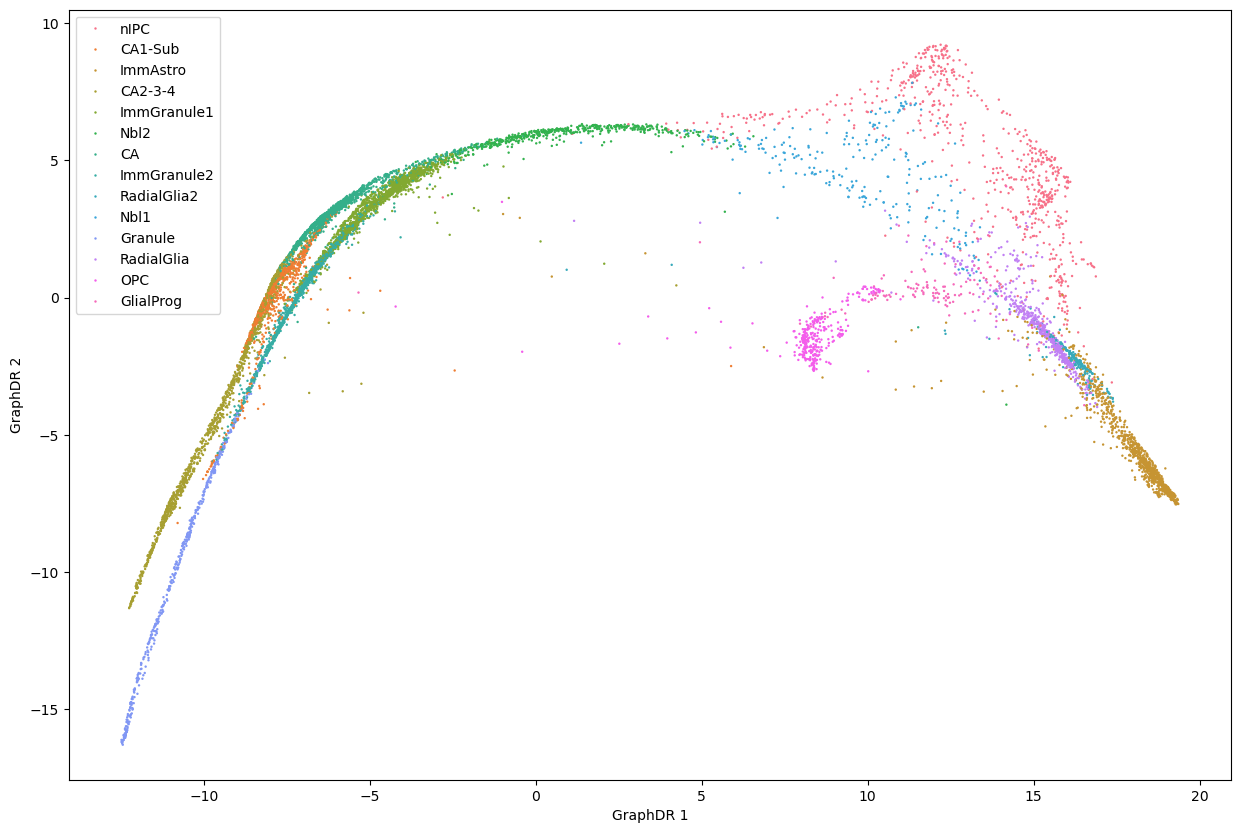

In [45]:
# Apply GraphDR
graphdr_data  = graphdr(pca_data, lambda_=5, no_rotation=False)
plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')
plt.show()

Text(0, 0.5, 'GraphDR 2')

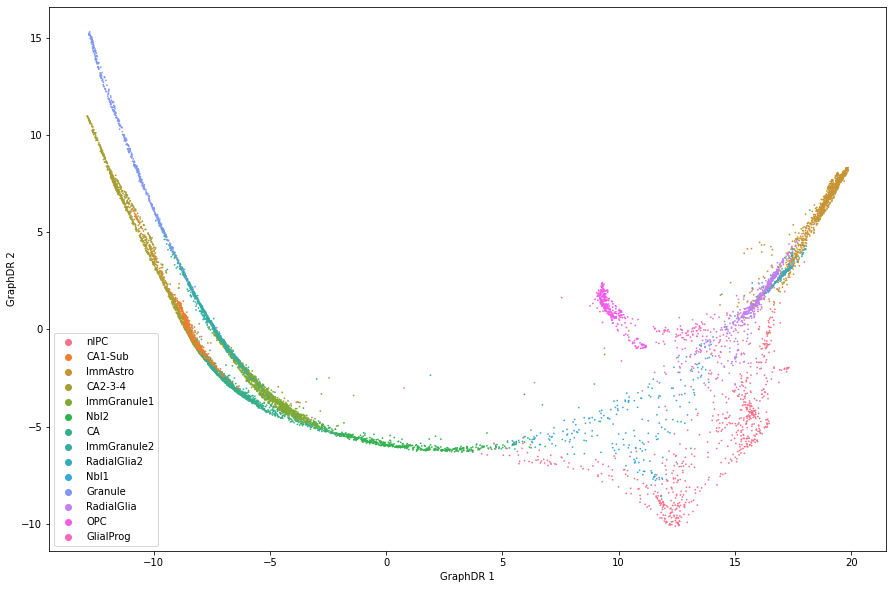

In [10]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
seaborn.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')